# Тренеровка модели и получение предварительных данных
Этот код являеться все целой копии "Basic tutorial for query to reference maping using expiMap" с небольшими доработками чтобы скрипт мог работать с иным набором данных.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown
import os

KeyboardInterrupt: 

In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
adata = sc.read('../dataset/tyser.h5ad')
hips = sc.read("../dataset/chen_subsampled_5000.h5ad")

In [5]:
adata.X=adata.raw.X.copy()

In [6]:
if not os.path.exists("../metadata/reactome.gmt"):
    url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
    output = "../metadata/reactome.gmt"
    gdown.download(url, output, quiet=False)

In [7]:
sca.utils.add_annotations(adata, '../metadata/reactome.gmt', min_genes=12, clean=True)

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [9]:
sc.pp.normalize_total(adata)
adata.X[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2038 stored elements and shape (1, 5655)>

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="sample_name",
    subset=True)

In [12]:
select_terms = adata.varm['I'].sum(0) > 12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [13]:
adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)


In [14]:
rawdata = adata.copy()

In [15]:
adata.raw.var

,_index
0,A1BG
1,A1BG.AS1
2,A1CF
3,A2M
4,A2M.AS1
...,...
57485,ZYG11B
57486,ZYX
57487,ZYXP1
57488,ZZEF1


In [16]:
adata.X[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 515 stored elements and shape (1, 1977)>

In [17]:
adata.X[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 515 stored elements and shape (1, 1977)>

In [18]:
rawdata.X.toarray()[0]

array([0.  , 0.  , 3.69, 1.48, 0.  , 0.  , 0.  , ..., 1.48, 0.  , 0.99,
       0.  , 0.  , 0.  , 2.42])

In [19]:
# Overlap bepalen tussen gen-namen in adata.raw.var en adata.var
overlap_mask = adata.raw.var['_index'].isin(adata.var['features'])

# Controleer of het masker overeenkomt met het aantal kolommen in adata.raw.X
print("Lengte van overlap_mask:", len(overlap_mask))
print("Aantal kolommen in adata.raw.X:", adata.raw.X.shape[1])

# Filter de matrix op basis van de overlappende genen
if len(overlap_mask) == adata.raw.X.shape[1]:
    # Omzetten naar dense matrix (indien nodig)
    raw_X_dense = adata.raw.X.toarray()
    
    # Filter de kolommvaren op basis van overlap_mask
    filtered_raw_X = raw_X_dense[:, overlap_mask.values]
    
    # Resultaat
    print("Gefilterde matrix shape:", filtered_raw_X.shape)
else:
    print("Dimensies komen niet overeen! Controleer adata.raw.var en adata.raw.X.")



# Stap 1: Zorg ervoor dat de gefilterde matrix in het float32 formaat is
filtered_raw_X_float32 = filtered_raw_X.astype(np.float32)

# Stap 2: Optioneel: Sla de matrix op als een numpy-bestand
np.save('filtered_raw_X_float32.npy', filtered_raw_X_float32)

# Stap 3: Kopieer de matrix naar adata.X
adata.X = filtered_raw_X_float32

# Controleer de dimensies en het datatype van adata.X
print("Vorm van adata.X:", adata.X.shape)
print("Datatype van adata.X:", adata.X.dtype)

Lengte van overlap_mask: 57490
Aantal kolommen in adata.raw.X: 57490
Gefilterde matrix shape: (1069, 1977)
Vorm van adata.X: (1069, 1977)
Datatype van adata.X: float32


In [20]:
missing_genes = [gene for gene in adata.var_names if gene not in hips.var_names]
print(f"Aantal genen in hips die niet in tyser staan: {len(missing_genes)}")
print("Ontbrekende genen:", missing_genes)

Aantal genen in hips die niet in tyser staan: 53
Ontbrekende genen: ['C1QB', 'C1QC', 'CCL3L3', 'CCL4', 'CD40LG', 'CHRNA6', 'CHRNB3', 'CTGF', 'CTSG', 'CX3CR1', 'DEFB104A', 'ENPP7', 'FMO2', 'FPR1', 'GBA3', 'GP9', 'GPR65', 'GPX1', 'HBD', 'HK3', 'HTR5A', 'IL3', 'LILRA1', 'LILRB2', 'MC3R', 'MMRN1', 'MTNR1A', 'NLRC4', 'NPSR1', 'OASL', 'OR14A16', 'OR2A42', 'OR2L13', 'OR2W3', 'OR3A1', 'OR3A2', 'OR51E1', 'OR51E2', 'OR51L1', 'OR6V1', 'OR8K1', 'PLA2G16', 'PLXNB3', 'PNLIPRP2', 'QRFP', 'RPS19P3', 'RPSAP9', 'SLC10A1', 'SRD5A2', 'SSTR4', 'TAS1R2', 'VAV1', 'ZNF658B']


In [21]:
commom = adata.var_names.intersection(hips.var_names)
hips = hips[:, commom].copy()
adata = adata[:, commom].copy()


In [22]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='sample_name',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1924 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 1 1924
	with hard mask.
Last Decoder layer: softmax


In [23]:
ALPHA = 0.7

adata.X = adata.X.astype(np.float32)

In [24]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (1069, 1924)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 2907.4104919434 - epoch_recon_loss: 2753.5400390625 - epoch_kl_loss: 307.7408409119 - val_loss: 3105.1323242188 - val_recon_loss: 2957.7687988281 - val_kl_loss: 294.726837158244
Saving best state of network...
Best State was in Epoch 399


In [25]:
MEAN = False

In [26]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [27]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [28]:
sc.tl.umap(adata)

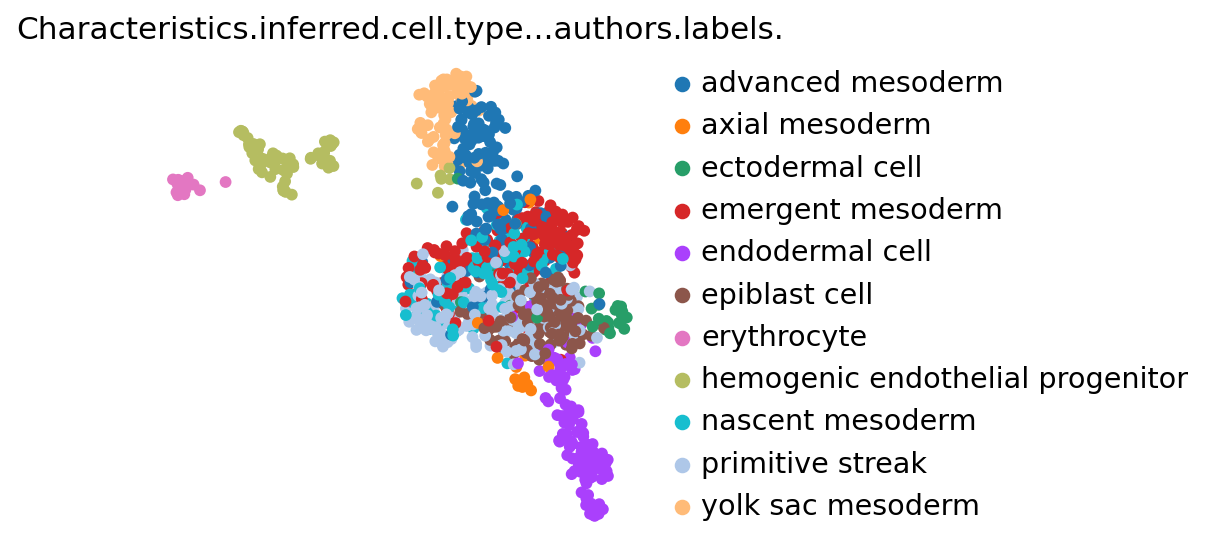

In [29]:
sc.pl.umap(adata, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False)

In [30]:
hips.X = hips.X.astype(np.float32)


In [36]:
hips.obs = hips.obs.rename(columns={"sample_id":"sample_name"})

In [37]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(hips, intr_cvae)

AnnData object with n_obs × n_vars = 5000 × 1924
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_name', 'replicate', 'timepoint', 'percent.mt', 'percent.dissoc', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_mnn', 'X_umap'
    obsp: 'distances'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1924 256 13
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 13 1924
	with hard mask.
Last Decoder layer: softmax


In [38]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)


Preparing (5000, 1924)
Instantiating dataset
 |███████████████████-| 97.2%  - val_loss: 1001.0634307861 - val_recon_loss: 987.1395721436 - val_kl_loss: 139.23859405526
ADJUSTED LR
 |████████████████████| 100.0%  - val_loss: 999.8499145508 - val_recon_loss: 985.9340667725 - val_kl_loss: 139.1582946777
Saving best state of network...
Best State was in Epoch 399


In [39]:
dataset_samen = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')



In [40]:
dataset_samen.X = dataset_samen.X.astype(np.float32)


In [41]:
dataset_samen.obsm['X_cvae'] = q_intr_cvae.get_latent(dataset_samen.X, dataset_samen.obs['sample_name'], mean=MEAN, only_active=True)

In [42]:
sc.pp.neighbors(dataset_samen, use_rep='X_cvae')

In [43]:
sc.tl.umap(dataset_samen)


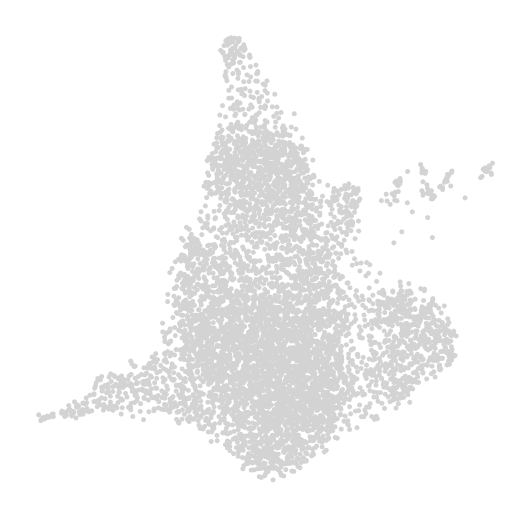

In [44]:
sc.pl.umap(dataset_samen, frameon=False, wspace=0.6)


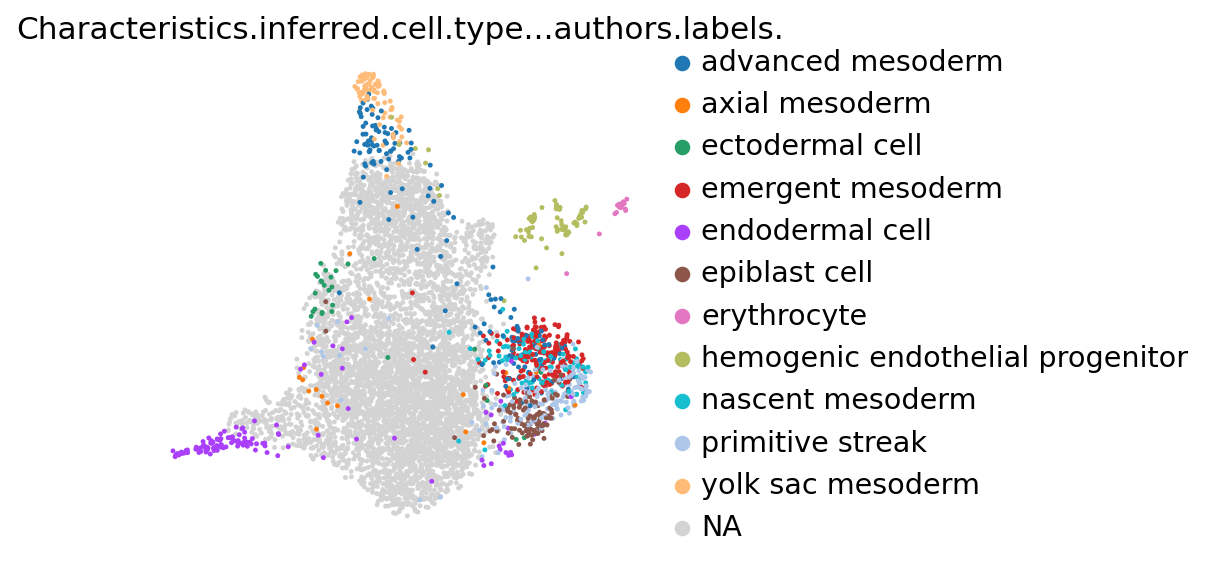

In [45]:
sc.pl.umap(dataset_samen, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False, wspace=0.6)

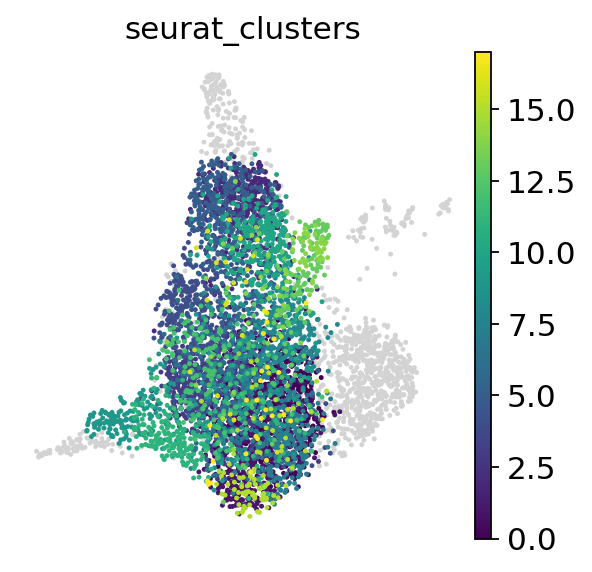

In [46]:

sc.pl.umap(dataset_samen, color=['seurat_clusters'], frameon=False, wspace=0.6)

In [47]:
# dataset_samen.obs['orig.ident'] = dataset_samen.obs['orig.ident'].astype(str)


# dataset_samen.write('hipstyser_integrated.h5ad')